# 数据处理和分析

## 聚合初步清洗和筛选出的数据

由于数据集中数据的质量较差，我们对数据集进行了人工的清洗和筛选

In [34]:
import pandas as pd

In [37]:
import re

In [19]:
py_data1 = pd.read_csv('./py/dl_py_clean1.csv')
py_data2 = pd.read_csv('./py/dl_py_clean2.csv')
py_data3 = pd.read_csv('./py/dl_py_clean3.csv')

In [24]:
py_data = pd.concat([py_data1, py_data2, py_data3])

In [25]:
py_data.describe()

,buggy_code,fixed_code
count,275,275
unique,269,269
top,if it % 100 == 0:\nprint('Iteration %d -- Oute...,if it % 100 == 0:\nprint('Iteration %d -- Oute...
freq,3,3


In [29]:
cpp_data1 = pd.read_csv('./cpp/dl_cpp_clean1.csv')
cpp_data2 = pd.read_csv('./cpp/dl_cpp_clean2.csv')
cpp_data3 = pd.read_csv('./cpp/dl_cpp_clean3.csv')

In [30]:
cpp_data = pd.concat([cpp_data1, cpp_data2, cpp_data3])

In [31]:
cpp_data.describe()

,buggy_code,fixed_code
count,359,359
unique,331,331
top,const auto source_n = n->sourceRange().source(...,const auto source_n = n->sourceRange().source(...
freq,3,3


经过我们的人工清洗和筛选，可以看出，有效的数据非常少，在提供的总共 12000 条左右的数据中，有效的数据只有不到 700 条.

In [32]:
py_data.to_csv('./final_data/dl_py.csv', index=False)

In [33]:
cpp_data.to_csv('./final_data/dl_cpp.csv', index=False)

得到了聚合之后的数据，我们使用简单的词法分析工具来对程序片段进行 tokenize, 这里我们使用 Antlr 来生成词法分析器，详情可见 Github 页面 [SimpleLexicalTools](https://github.com/SUNLIFAN/SimpleLexicalTools)

## 分析 tokenization 之后的程序片段

In [46]:
tokenized_py = pd.read_csv('./final_tokenized_data/dl_py_tokenized.csv')

In [47]:
tokenized_cpp = pd.read_csv('./final_tokenized_data/dl_cpp_tokenized.csv')

In [50]:
tokenized_py.head()

,BUGGY_CODE,FIXED_CODE
0,def __sizeof__ ( self ) : return super ( _Stor...,def __sizeof__ ( self ) : return ( super ( _St...
1,self . quant_min : int = quant_min self . quan...,self . quant_min : int = quant_min self . quan...
2,def get_default_qat_qconfig ( backend = gemm v...,def get_default_qat_qconfig ( backend = gemm v...
3,"exp_avg . mul_ ( beta1 ) . add_ ( grad , alpha...","exp_avg . mul_ ( beta1 ) . add_ ( grad , alpha..."
4,def get_post_build_suffix ( self ) -> str : if...,def get_post_build_suffix ( self ) -> str : if...


In [51]:
tokenized_cpp.head()

,BUGGY_CODE,FIXED_CODE
0,std::shared_ptr<ProcessGroupNCCL::WorkNCCL> Pr...,std::shared_ptr<ProcessGroupNCCL::WorkNCCL> Pr...
1,std::chrono::milliseconds ( kWaitForAbortCommS...,std::chrono::milliseconds ( kWaitForAbortCommS...
2,if ( rank_ == 0 | | ( commType != NCCLCommType...,if ( rank_ == 0 | | ( isP2POp ( opType ) & & p...
3,"int numRanks , rank ; if ( commType == NCCLCom...","int numRanks , rank ; if ( sP2POp ( opType ) )..."
4,"if ( str != ""None"" & & str != """" ) { throw std...","if ( str != ""None"" ) { default_string = parse_..."


In [52]:
def get_len_in_tokens(data):
    len_in_tokens = []
    data_len = data.shape[0]
    for i in range(data_len):
        buggy_code = data.iloc[i]['BUGGY_CODE']
        fixed_code = data.iloc[i]['FIXED_CODE']
        buggy_tokens = re.split('\s+', buggy_code)
        fixed_tokens = re.split('\s+', fixed_code)
        len_in_tokens.append(max(len(buggy_tokens), len(fixed_tokens)))
    return len_in_tokens

In [53]:
py_len_in_tokens = get_len_in_tokens(tokenized_py)

In [54]:
print('max len in tokens of py code', max(py_len_in_tokens))

max len in tokens of py code 102


In [56]:
print('avg len in tokens of py code', int(sum(py_len_in_tokens) / len(py_len_in_tokens)))

avg len in tokens of py code 47


In [57]:
cpp_len_in_tokens = get_len_in_tokens(tokenized_cpp)

In [58]:
print('max len in tokens of cpp code', max(cpp_len_in_tokens))

max len in tokens of cpp code 127


In [59]:
print('avg len in tokens of cpp code', int(sum(cpp_len_in_tokens) / len(cpp_len_in_tokens)))

avg len in tokens of cpp code 46


下面分别看一下 python 和 cpp 程序片段的 token 数量的分布

In [114]:
import matplotlib.pyplot as plt

In [69]:
py_len_in_tokens = sorted(py_len_in_tokens)
cpp_len_in_tokens = sorted(cpp_len_in_tokens)

In [73]:
freq_py_tokens = [0] * (max(py_len_in_tokens) + 10)
freq_cpp_tokens = [0] * (max(cpp_len_in_tokens) + 10)

In [74]:
for token_len in py_len_in_tokens:
    freq_py_tokens[token_len] += 1
for token_len in cpp_len_in_tokens:
    freq_cpp_tokens[token_len] += 1

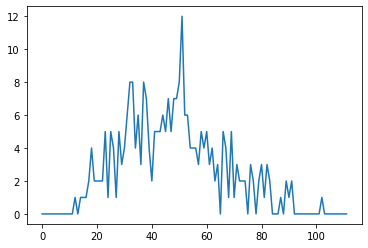

In [116]:
plt.plot(list(range(len(freq_py_tokens))), freq_py_tokens)
plt.show()

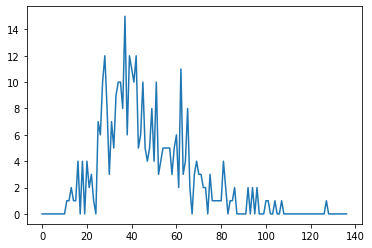

In [117]:
plt.plot(list(range(len(freq_cpp_tokens))), freq_cpp_tokens)
plt.show()

根据得到的数据我们绘制了 token 数量频率的分布图，可以看到基本上所有的程序片段长度都在 100 个 token 以下，并且 60 个 token 以下的

In [61]:
def get_all_vocab(data):
    vocab = []
    data_len = data.shape[0]
    for i in range(data_len):
        tokens = re.split('\s+', data.iloc[i]['BUGGY_CODE'])
        vocab += tokens
        tokens = re.split('\s+', data.iloc[i]['FIXED_CODE'])
        vocab += tokens
    return list(set(vocab))

In [62]:
py_vocab = get_all_vocab(tokenized_py)

In [63]:
cpp_vocab = get_all_vocab(tokenized_cpp)

In [64]:
len(py_vocab)

1866

In [65]:
len(cpp_vocab)

2009

在以往一些基于深度学习的程序修复技术的研究中，会对代码片段进行 Code Abstraction，以解决 vocabulary 太大的问题，但是这里并不太多，并且由于数据集中的程序片段过于残破，无法进行语法分析，故不进行 Code Abstraction 的处理.